In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('./spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


C:\Users\pc\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Minimum Validation Loss: 0.1944


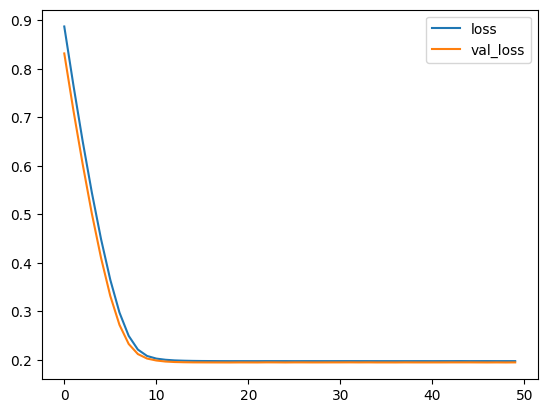

In [16]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Minimum Validation Loss: 0.1944


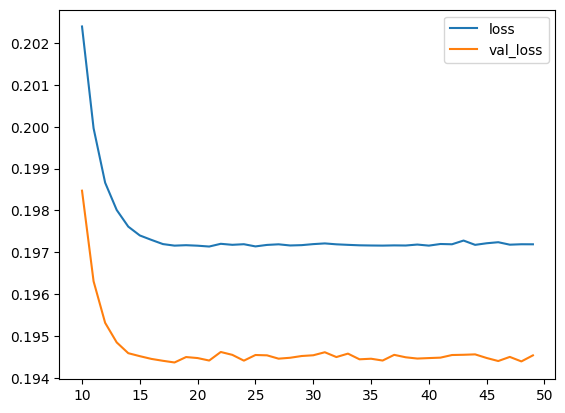

In [17]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Epoch 1/50


C:\Users\pc\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2793 - val_loss: 0.2066
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2032 - val_loss: 0.1995
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1980 - val_loss: 0.1977
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1954 - val_loss: 0.1962
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1933 - val_loss: 0.1959
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1914 - val_loss: 0.1959
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1906 - val_loss: 0.1949
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1892 - val_loss: 0.1947
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1878 - val_loss: 0.1953
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1874 - val_loss: 0.1950
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1865 - val_loss: 0.1949
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1855 - val_loss: 0.1954

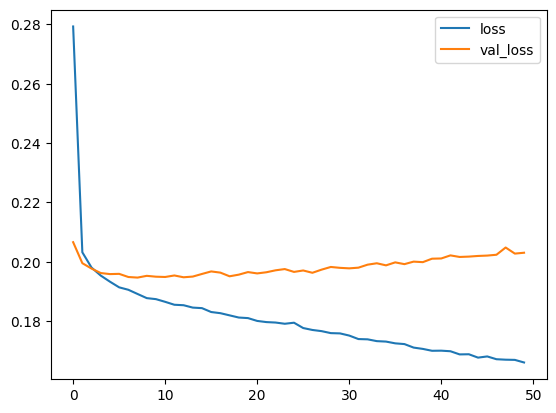

In [18]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

Epoch 1/50


C:\Users\pc\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2436 - val_loss: 0.2039
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2016 - val_loss: 0.1979
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1965 - val_loss: 0.1975
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1944 - val_loss: 0.1950
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1921 - val_loss: 0.1957
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1902 - val_loss: 0.1948
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1885 - val_loss: 0.1945
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1877 - val_loss: 0.1938
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1870 - val_loss: 0.1948
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1858 - val_loss: 0.1947
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1852 - val_loss: 0.1935
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1837 - val_loss: 0.1957


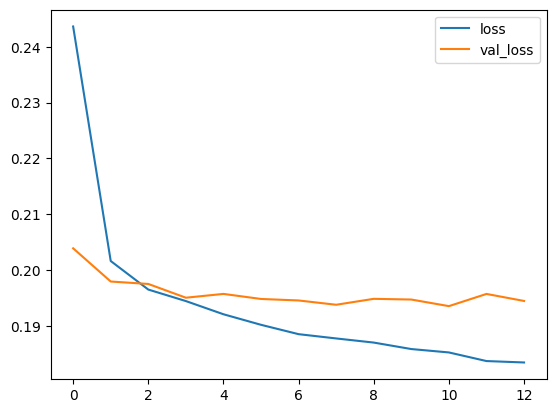

In [20]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));